## Plot bias and var v.s. inner batch size

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "ps.usedistiller": "xpdf",
    }
)


def plot_curves_with_shadow(ax, curves_x, curves_y, color, label, **kwargs):
    subsample = 2
    # Create a common set of x-values
    common_x = np.sort(np.unique(np.concatenate(curves_x)))

    # Interpolate y-values for each curve at the common set of x-values
    interpolated_curves = []
    for x, y in zip(curves_x, curves_y):
        interpolated_y = np.interp(common_x, x, y)
        interpolated_curves.append(interpolated_y)

    # Calculate the average y-value at each x-value
    average_y = np.mean(interpolated_curves, axis=0)

    # Subsample the common x and y values
    subsampled_x = common_x[::subsample]
    subsampled_y = average_y[::subsample]

    # Plot the average curve and fill the area between the curves and the average curve
    ax.plot(subsampled_x, subsampled_y, label=label, color=color, **kwargs)
    for y in interpolated_curves:
        ax.fill_between(
            subsampled_x,
            y[::subsample],
            subsampled_y,
            alpha=0.1,
            color=color,
            linewidth=0.0,
        )

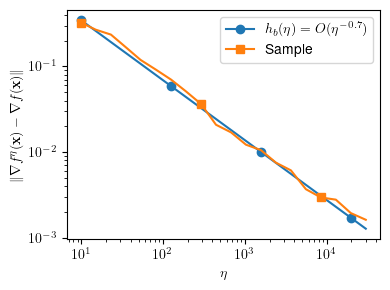

In [4]:
# Load the results
results = torch.load("data/digit/bias_sample/avg_var_results.pt")


plt.figure(figsize=(4, 3))


plt.plot(
    results["eta"],
    1.73 * (torch.tensor(results["eta"])).pow(-0.7),
    label=r"$h_b(\eta) = O(\eta^{-0.7})$",marker="o", markevery=6
)
plt.plot(results["eta"],
    torch.norm(results["avg_bias"] - results["full_grad"], dim=1), label="Sample", marker="s", markevery=8)
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\| \nabla f^\eta(\mathbf{x}) - \nabla f(\mathbf{x})\|$")
plt.yscale("log")
plt.xscale("log")
plt.legend()

plt.tight_layout()

plt.savefig("plots/DRO_bias_fit.pdf", bbox_inches="tight")



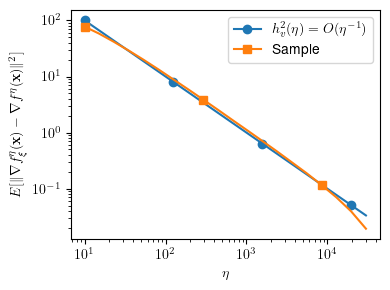

In [5]:
plt.figure(figsize=(4, 3))


plt.plot(
    results["eta"],
    1000 * torch.tensor(results["eta"]).pow(-1.0),marker="o", markevery=6,label=r"$h_v^2(\eta) = O(\eta^{-1})$"
)
plt.plot(results["eta"], results["var_bias"], label="Sample", marker="s", markevery=8)
plt.xlabel(r"$\eta$")
plt.ylabel(r"$E[\|\nabla f^{\eta}_\xi(\mathbf{x})- \nabla f^{\eta}(\mathbf{x})\|^2]$")
plt.yscale("log")
plt.xscale("log")
plt.legend()

plt.tight_layout()

plt.savefig("plots/DRO_var_fit.pdf", bbox_inches="tight")





In [4]:
# fitting the bias plot with a line
eta_tofit = torch.log10(torch.tensor(results["eta"]).float())
bias_tofit = torch.log10(
    torch.norm(results["avg_bias"] - results["full_grad"], dim=1).pow(2.0)
)

coeffs_bias = np.polyfit(eta_tofit, bias_tofit, deg=1)
print(coeffs_bias)

var_tofit = torch.log10(results["var_bias"])
coeffs_var = np.polyfit(eta_tofit, var_tofit, deg=1)
print(coeffs_var)


[-1.40194008  0.53520528]
[-1.01616611  3.04066571]


In [6]:
import os, copy

result_dir = "results/main/regl11e-04"

algorithms = []

# list folder names as keys of algorithms
for folder in os.listdir(result_dir):
    algorithms.append(folder)

algorithms.remove(".DS_Store")
print(algorithms)

# create a dictionary with key in algorithms
metrics = ["train_loss", "train_grad_norm", "total_loss", "full_grad_norm"]
results = {key: [] for key in metrics}
results["xaxis_train"] = []
results["xaxis_eval"] = []
results["batch_size"] = []

['Multistage_STORM', 'proxSGD', 'proxABG', 'ABG_STORM', 'multilevel', 'dual', 'primaldual']


# Load data

In [7]:
results_proxABG = {}
results_proxSGD = {}
results_ABG_STORM = {}
results_Multi_STORM = {}
results_dual = copy.deepcopy(results)
results_primaldual = copy.deepcopy(results)
results_multilevel = copy.deepcopy(results)
results_Multi_STORM = copy.deepcopy(results)

for folder in ["proxABG", "ABG_STORM", "proxSGD", "dual", "primaldual", "multilevel","Multistage_STORM"]:
    for file in os.listdir(os.path.join(result_dir, folder)):
        if file.endswith("logger.pt"):
            file_name = os.path.join(result_dir, folder, file)
            result = torch.load(file_name)

            if folder == "proxABG":
                initial_name = "_".join(file.split("_")[:-2])
                if initial_name not in results_proxABG:
                    results_proxABG[initial_name] = copy.deepcopy(results)
                results_dict = results_proxABG[initial_name]

            elif folder == "ABG_STORM":
                initial_name = "_".join(file.split("_")[:-2])
                if initial_name not in results_ABG_STORM:
                    results_ABG_STORM[initial_name] = copy.deepcopy(results)
                results_dict = results_ABG_STORM[initial_name]

            elif folder == "proxSGD":
                initial_name = file.split("_")[0]
                if initial_name not in results_proxSGD:
                    results_proxSGD[initial_name] = copy.deepcopy(results)
                results_dict = results_proxSGD[initial_name]

            elif folder == "dual":
                results_dict = results_dual

            elif folder == "primaldual":
                results_dict = results_primaldual

            elif folder == "multilevel":
                results_dict = results_multilevel

            elif folder == "Multistage_STORM":
                results_dict = results_Multi_STORM

            results_dict["train_loss"].append(
                result["train_metrics"]["average"]["loss"]
            )
            results_dict["train_grad_norm"].append(
                result["train_metrics"]["average"]["grad_norm"]
            )
            results_dict["xaxis_train"].append(result["train_metrics"]["total_sample"])
            results_dict["total_loss"].append(
                result["eval_metrics"]["average"]["total_loss"]
            )
            results_dict["full_grad_norm"].append(
                result["eval_metrics"]["average"]["full_grad_norm"]
            )
            results_dict["xaxis_eval"].append(result["eval_metrics"]["total_sample"])

            results_dict["batch_size"].append(
                result["train_metrics"]["per_iteration_sample"]
            )

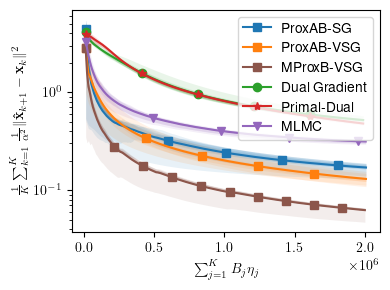

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))

plot_curves_with_shadow(
    axs,
    results_proxABG["batch10_step5e-04_multiplier1e+02_exponent-5.0"]["xaxis_eval"],
    results_proxABG["batch10_step5e-04_multiplier1e+02_exponent-5.0"]["full_grad_norm"],
    label="ProxAB-SG",
    color="C0",
    marker="s",
    markevery=200,
)

plot_curves_with_shadow(
    axs,
    results_ABG_STORM["batch10_step5e-03_multiplier1e+03_exponent-5.0_beta5e-01"][
        "xaxis_eval"
    ],
    results_ABG_STORM["batch10_step5e-03_multiplier1e+03_exponent-5.0_beta5e-01"][
        "full_grad_norm"
    ],
    label="ProxAB-VSG",
    color="C1",
    marker="s",
    markevery=200,
)

plot_curves_with_shadow(
    axs,
    results_Multi_STORM["xaxis_eval"],
    results_Multi_STORM["full_grad_norm"],
    label="MProxB-VSG",
    color="C5",
    marker="s",
    markevery=20,
)

plot_curves_with_shadow(
    axs,
    results_dual["xaxis_eval"],
    results_dual["full_grad_norm"],
    label="Dual Gradient",
    color="C2",
    marker="o",
    markevery=20,
)
plot_curves_with_shadow(
    axs,
    results_primaldual["xaxis_eval"],
    results_primaldual["full_grad_norm"],
    label="Primal-Dual",
    color="C3",
    marker="*",
    markevery=20,
)
plot_curves_with_shadow(
    axs,
    results_multilevel["xaxis_eval"],
    results_multilevel["full_grad_norm"],
    label="MLMC",
    color="C4",
    marker="v",
    markevery=200,
)




axs.set(
    xlabel=r"$\sum_{j=1}^KB_j\eta_j$",
    ylabel=r"$\frac{1}{K} \sum_{k=1}^K \frac{1}{\alpha^2}\| \mathbf{\hat{x}}_{k+1} - \mathbf{x}_k\|^2$",
    yscale="log",
)

axs.legend()
fig.tight_layout()

fig.savefig("plots/DRO-compare-distance.pdf")

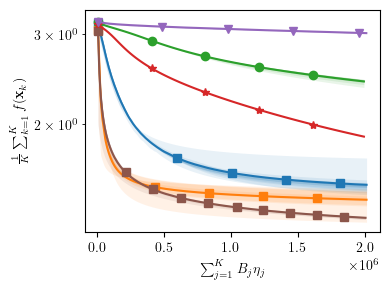

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))


plot_curves_with_shadow(
    axs,
    results_proxABG["batch10_step5e-04_multiplier1e+02_exponent-5.0"]["xaxis_eval"],
    results_proxABG["batch10_step5e-04_multiplier1e+02_exponent-5.0"]["total_loss"],
    label="proxABG",
    color="C0",
    marker="s",
    markevery=200,
)

plot_curves_with_shadow(
    axs,
    results_ABG_STORM["batch10_step5e-03_multiplier1e+03_exponent-5.0_beta5e-01"][
        "xaxis_eval"
    ],
    results_ABG_STORM["batch10_step5e-03_multiplier1e+03_exponent-5.0_beta5e-01"][
        "total_loss"
    ],
    label="proxABGD-STORM",
    color="C1",
    marker="s",
    markevery=200,
)

plot_curves_with_shadow(
    axs,
    results_Multi_STORM["xaxis_eval"],
    results_Multi_STORM["total_loss"],
    label="Multistage-STORM",
    color="C5",
    marker="s",
    markevery=20,

)

plot_curves_with_shadow(
    axs,
    results_dual["xaxis_eval"],
    results_dual["total_loss"],
    label="dual",
    color="C2",
    marker="o",
    markevery=20,
)
plot_curves_with_shadow(
    axs,
    results_primaldual["xaxis_eval"],
    results_primaldual["total_loss"],
    label="primaldual",
    color="C3",
    marker="*",
    markevery=20,
)
plot_curves_with_shadow(
    axs,
    results_multilevel["xaxis_eval"],
    results_multilevel["total_loss"],
    label="multilevel",
    color="C4",
    marker="v",
    markevery=200,
)


axs.set(
    xlabel=r"$\sum_{j=1}^KB_j\eta_j$", ylabel=r"$\frac{1}{K}\sum_{k=1}^K f(\mathbf{x}_k)$", yscale="log"
)

fig.tight_layout()

fig.savefig("plots/DRO-compare-obj.pdf")